# Analysis

In [1]:
import numpy as np
import g3read as g3
import matplotlib.pyplot as plt

In [2]:
#quants = [0.005, 0.995]
#quants = [0.025, 0.975]
quants = [0.05, 0.95]
n = 70
figsize1 = (10,5) #now: xlim(-38,38);(10,6)at plt.xlim(-50,50) and plt.ylim(-30,30) #default was (25,5) at plt.xlim(-100,100) and plt.ylim(-30,30)
figsize2 = (18,6)
figsize3 = (7.5,6)

## merger class

In [3]:
class Merger():
    "Class to analyse a galaxy merger edge on"
    
    def __init__(self, data_filename='counter_050'):
        """
        Initialise arrays and variables.
        
        Optional parameter:
        ----------
        data_filename : the filename that contains the simulation data. Defaults to 'counter_050'

        """
        f = g3.GadgetFile(data_filename)
        ptype = [0,2,3]
        
        self.pos_dm = g3.read_new(data_filename, 'POS ', 1)
        self.vel_dm = g3.read_new(data_filename, 'VEL ', 1)
        self.mass_dm = g3.read_new(data_filename, 'MASS', 1)
        
        self.pos_bar = g3.read_new(data_filename, 'POS ', ptype)
        self.vel_bar = g3.read_new(data_filename, 'VEL ', ptype)
        self.mass_bar = g3.read_new(data_filename, 'MASS', ptype)
        
        self.pos = g3.read_new(data_filename, 'POS ', -1)
        self.vel = g3.read_new(data_filename, 'VEL ', -1)
        self.mass = g3.read_new(data_filename, 'MASS',-1)
        
        self.com = np.array([0,0,0])
        self.vel_com = np.array([0,0,0])
        
        self.time = f.header.time
        
        self.x_min = np.quantile(self.pos_bar[:,1], quants[0])
        self.x_max = np.quantile(self.pos_bar[:,1], quants[1])
        
        self.y_min = np.quantile(self.pos_bar[:,2], quants[0])
        self.y_max = np.quantile(self.pos_bar[:,2], quants[1])
        
        #r_eff, c = self.effective_radius()
        
        #self.x_min = -2*r_eff
        #self.x_max = 2*r_eff
        
        #self.y_min = -2*r_eff
        #self.y_max = 2*r_eff
        
        self.x = np.zeros(50)
        self.y = np.zeros(50)
        
        self.los_vel = np.zeros((50,50))
        self.los_sig = np.zeros((50,50))
        
        self.lambda_R = 0.5
        
    def calc_com(self):
        self.com = np.dot(self.pos.transpose(),self.mass)/np.sum(self.mass)
        self.vel_com = np.dot(self.vel.transpose(), self.mass)/np.sum(self.mass)
        
        self.pos = self.pos - self.com
        self.vel = self.vel - self.vel_com
        
        self.pos_dm = self.pos_dm - self.com
        self.vel_dm = self.vel_dm - self.vel_com
        
        self.pos_bar = self.pos_bar - self.com
        self.vel_bar = self.vel_bar - self.vel_com
        
        self.x_min = np.quantile(self.pos_bar[:,1], quants[0])
        self.x_max = np.quantile(self.pos_bar[:,1], quants[1])
        
        self.y_min = np.quantile(self.pos_bar[:,2], quants[0])
        self.y_max = np.quantile(self.pos_bar[:,2], quants[1])
    
        #r_eff, c = self.effective_radius()
        
        #self.x_min = -2*r_eff
        #self.x_max = 2*r_eff
        
        #self.y_min = -2*r_eff
        #self.y_max = 2*r_eff
        
    def plot(self):
        sort_ind = np.argsort(self.pos_bar[:,0])
        self.pos_bar = self.pos_bar[sort_ind]
        self.vel_bar = self.vel_bar[sort_ind]
        
        fig= plt.figure(figsize = figsize1, dpi = 80) #figsize = (25,5)
        plt.scatter(self.pos_dm[:,1], self.pos_dm[:,2], marker = '.',s = .5, c = 'gray')
        plt.scatter(self.pos_bar[:,1], self.pos_bar[:,2], marker = '.', c = self.vel_bar[:,0], s = .5, cmap = 'jet_r', vmin = -200, vmax = 200)
    
        cbar = plt.colorbar()
        cbar.set_label(r'$v_{los} [km/s]$')
                    
        plt.plot(0,0, 'r.')
        
        plt.axhline(y = self.y_min, color = 'red')
        plt.axhline(y = self.y_max, color = 'red')
        plt.axvline(x = self.x_min, color = 'red')
        plt.axvline(x = self.x_max, color = 'red')

        #plt.xlim(-100,100)
        #plt.xlim(-50,50)
        plt.xlim(-38,38)
        plt.ylim(-30,30)
    
        plt.xlabel('y [kpc]')
        plt.ylabel('x [kpc]')
    
        plt.title(f'merger at time = {self.time:.3f}')
        plt.show()
        
    def grid(self, n_x = 50, n_y = 50):
        
        x_edges = np.linspace(self.x_min, self.x_max, n_x+1)
        y_edges = np.linspace(self.y_min, self.y_max, n_y+1)
        
        x_centers = 0.5*(x_edges[1:]+x_edges[:-1])
        y_centers = 0.5*(y_edges[1:]+y_edges[:-1]) 
        
        lam_R_enum = np.zeros((n_x, n_y), dtype = np.float64)
        lam_R_denom = np.zeros((n_x, n_y), dtype = np.float64)
        
        V_array = np.zeros((n_x, n_y), dtype = np.float64)
        sig_array = np.zeros((n_x, n_y), dtype = np.float64)
        
        for i in range(len(x_centers)):
            for j in range(len(y_centers)):
                
                R = np.sqrt(x_centers[i]**2 + y_centers[j]**2)
                
                cond = np.where( (self.pos_bar[:,1] > x_edges[i]) & (self.pos_bar[:,1] < x_edges[i+1]) & (self.pos_bar[:,2] > y_edges[j]) & (self.pos_bar[:,2] < y_edges[j+1]) )
                vel_bin = self.vel_bar[:,0][cond]
                
                V = np.mean(vel_bin)
                sig = np.std(vel_bin)
                
                lam_R_enum[i,j] = R*np.abs(V)
                lam_R_denom[i,j] = R*np.sqrt(V**2 + sig**2)
                
                V_array[i,j] = V
                sig_array[i,j] = sig
                
        lam_R_enum = np.nan_to_num(lam_R_enum, copy=True, nan=0.0, posinf=None, neginf=None)
        lam_R_denom = np.nan_to_num(lam_R_denom, copy=True, nan=0.0, posinf=None, neginf=None)
        
        V_array = np.nan_to_num(V_array, copy=True, nan=0.0, posinf=None, neginf=None)
        sig_array = np.nan_to_num(sig_array, copy=True, nan=0.0, posinf=None, neginf=None)
        
        self.x = x_centers
        self.y = y_centers
        
        self.los_vel = V_array
        self.los_sig = sig_array
        
        self.lambda_R = np.sum(lam_R_enum)/np.sum(lam_R_denom)   
    
    def plot_both(self):
        """
        Plot the 2d l.o.s.-velocity and l.o.s.-velocity dispersion
        """
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize= figsize2)

        x = self.x
        y = self.y
        z = self.los_vel.transpose()
        z2 = self.los_sig.transpose()
        
        x_mesh, y_mesh = np.meshgrid(x,y)
        
        #plot los velocity
        #contours_vel = axes[0].contour(x_mesh, y_mesh, z, levels = [np.quantile(z,0.393)], colors='black')
        #axes[0].clabel(contours_vel, inline=True, fontsize=8)
        im_vel = axes[0].imshow(z, extent=[self.x_min, self.x_max, self.y_min, self.y_max], origin='lower',
           cmap='jet_r', alpha=0.7, aspect="auto", vmin = np.quantile(z, 0.1), vmax = np.quantile(z,0.9))
        cbar_chi = plt.colorbar(im_vel, ax = axes[0])
        
        axes[0].set_title(r"l.o.s. velocity [km/s]")
        axes[0].set_xlabel('y [kpc]')
        axes[0].set_ylabel('x [kpc]')
        
        
        #plot los velocity dispersion
        #contours_sig = axes[1].contour(x_mesh, y_mesh, z2, levels = [np.quantile(z2,0.393)], colors='black')
        #axes[1].clabel(contours_sig, inline=True, fontsize=8)
        im_sig = axes[1].imshow(z2, extent=[self.x_min, self.x_max, self.y_min, self.y_max], origin='lower',
           cmap='jet_r', alpha=0.7, aspect="auto", vmin = np.quantile(z2, 0.1), vmax = np.quantile(z2,0.9))
        cbar_like = plt.colorbar(im_sig, ax = axes[1])
        axes[1].set_title("l.o.s. velocity dispersion [km/s]")
        axes[1].set_xlabel('y [kpc]')
        axes[1].set_ylabel('x [kpc]')
        
        return axes
    
    def plot_vel(self):
        """
        Plot the 2d l.o.s.-velocity
        """
        fig = plt.figure(figsize= figsize3)

        x = self.x
        y = self.y
        z = self.los_vel.transpose()
        
        x_mesh, y_mesh = np.meshgrid(x,y)
        
        im_vel = plt.imshow(z, extent=[self.x_min, self.x_max, self.y_min, self.y_max], origin='lower',
           cmap='jet_r', alpha=0.7, aspect="auto", vmin = np.quantile(z, 0.1), vmax = np.quantile(z,0.9))
        cbar = plt.colorbar(im_vel)
        cbar.set_label(r'$v_{los} [km/s]$')
        
        #plt.title(r"l.o.s. velocity")
        plt.xlabel('y [kpc]')
        plt.ylabel('x [kpc]')
        
        return 0
    
    def plot_sig(self):
        """
        Plot the 2d l.o.s.-velocity dispersion
        """
        fig = plt.figure(figsize= figsize3)

        x = self.x
        y = self.y
        z = self.los_sig.transpose()
        
        x_mesh, y_mesh = np.meshgrid(x,y)
        
        im_vel = plt.imshow(z, extent=[self.x_min, self.x_max, self.y_min, self.y_max], origin='lower',
           cmap='jet_r', alpha=0.7, aspect="auto", vmin = np.quantile(z, 0.1), vmax = np.quantile(z,0.9))
        cbar = plt.colorbar(im_vel)
        cbar.set_label(r'$\sigma_{los} [km/s]$')
        
        plt.title(r"l.o.s. velocity dispersion")
        plt.xlabel('y [kpc]')
        plt.ylabel('x [kpc]')
        
        return 0
    
    def effective_radius(self, max_steps = 100):
        M_tot = np.sum(self.mass_bar)
        r_eff = 1
        r = np.sqrt(self.pos_bar[:,1]**2 + self.pos_bar[:,2]**2)
        cond = np.where(r < r_eff)
        M_half = np.sum(self.mass_bar[cond])
        counter = 0
        for i in range(max_steps):
            if (np.abs(M_tot/2-M_half) > 0.1 ):
                if M_tot/2 > M_half:
                    r_eff += 0.1
                elif M_tot/2 < M_half:
                    r_eff -= 0.1
                r = np.sqrt(self.pos_bar[:,0]**2 + self.pos_bar[:,1]**2 + self.pos_bar[:,2]**2)
                cond = np.where(r < r_eff)
                M_half = np.sum(self.mass_bar[cond])
                counter += 1
        return r_eff, counter


## counter simulation

In [4]:
merger = Merger(data_filename = 'counter_050')

In [5]:
merger.calc_com()

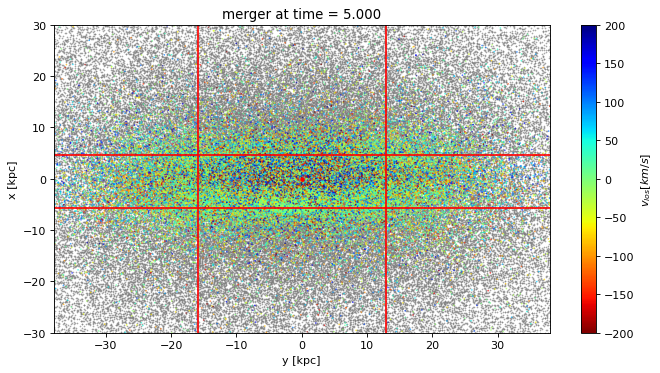

In [6]:
merger.plot()

In [7]:
merger.grid(n_x = n, n_y = n)
merger.lambda_R

C:\Users\johan\miniconda3\envs\basic\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\johan\miniconda3\envs\basic\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\johan\miniconda3\envs\basic\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\johan\miniconda3\envs\basic\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\johan\miniconda3\envs\basic\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.254503943551687

0

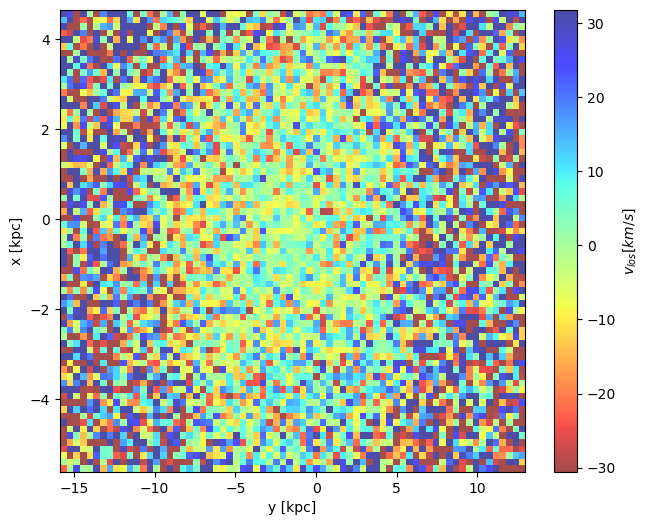

In [8]:
merger.plot_vel()

## same simulation

In [9]:
merger2 = Merger(data_filename = 'same_050')

In [10]:
merger2.calc_com()

In [11]:
merger2.effective_radius()

(6.099999999999995, 51)

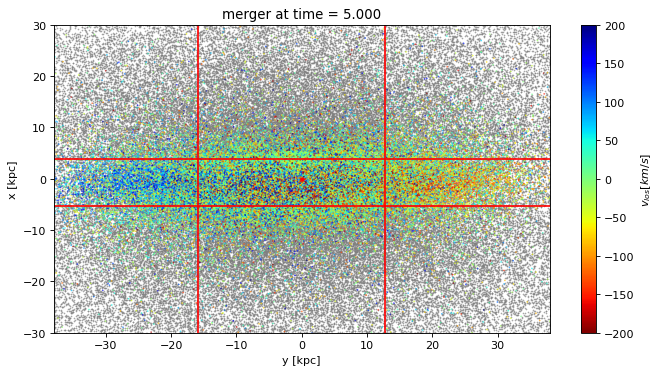

In [12]:
merger2.plot()

In [13]:
merger2.grid(n_x = n, n_y = n)
merger2.lambda_R

0.3079114014113047

0

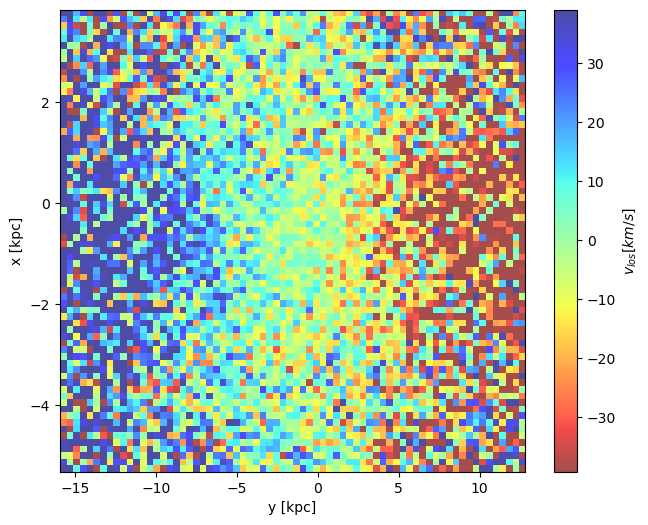

In [14]:
merger2.plot_vel()

## perp simulation

In [15]:
merger3 = Merger(data_filename = 'perp_050')

In [16]:
merger3.calc_com()

In [17]:
merger3.effective_radius()

(5.899999999999996, 49)

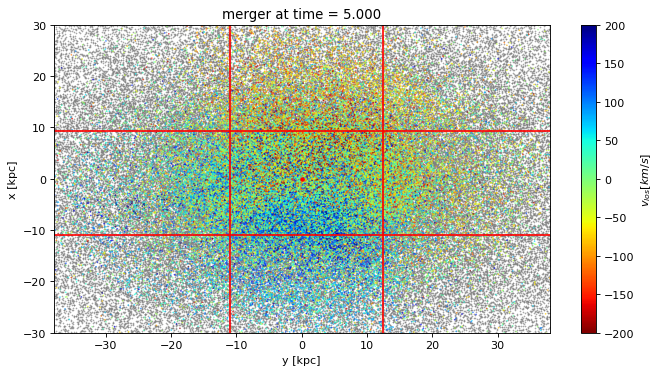

In [18]:
merger3.plot()

In [19]:
merger3.grid(n_x = n, n_y = n)
merger3.lambda_R

0.4097543558102553

0

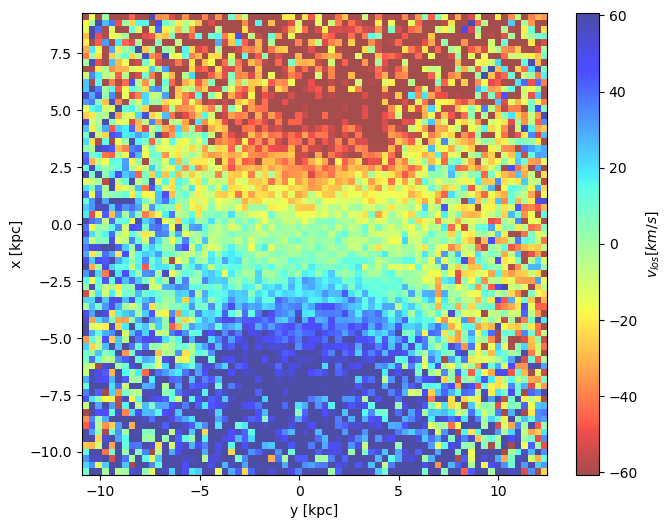

In [20]:
merger3.plot_vel()

## single galaxy

In [21]:
merger4 = Merger(data_filename = 'galaxy')

In [22]:
merger4.calc_com()

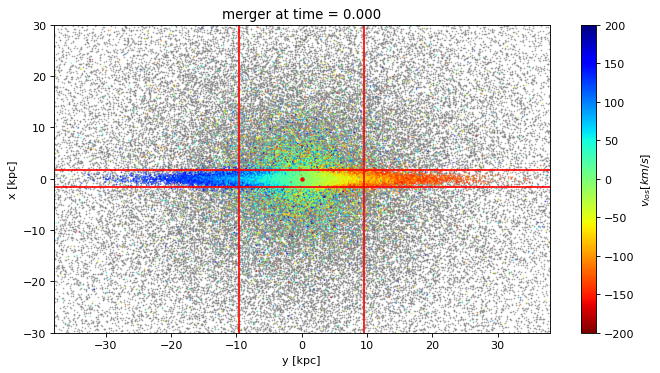

In [23]:
merger4.plot()

In [24]:
merger4.grid(n_x = n, n_y = n)
merger4.lambda_R

0.9143706636766059

0

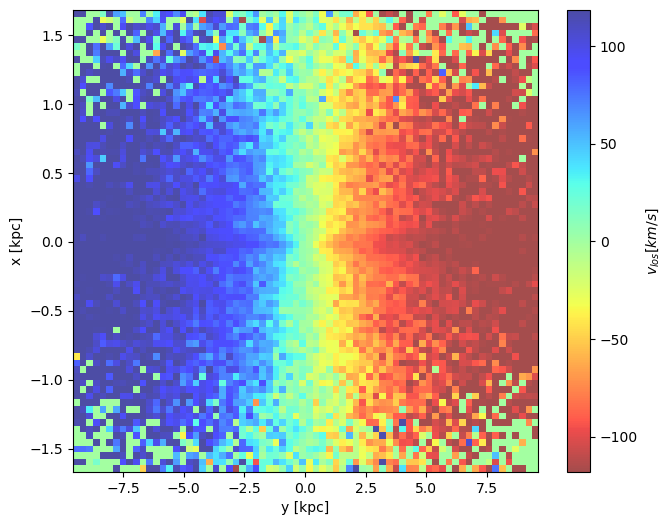

In [25]:
merger4.plot_vel()